In [1]:
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm

sys.path.append('../lib')
from storage import get_storage_functions
from local_paths import preproc_dir, analysis_dir
from self_consistency import find_return_fixations, pairwise_self_consistency

# Set parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'


#============================================================================
# response windows
#============================================================================
t_pre  = 100
t_post = 100
t_win  = 200
t_step =  50


#============================================================================
# return fixation selection
#============================================================================
return_thres  = 1  # dva
distant_thres = 8


#============================================================================
# temporal resolution
#============================================================================
# for summarizing trial duration and iti
dur_res = 100
iti_res =  50
min_dur = 200  # exclude these before finding most-common (mode) trial dur


#============================================================================
# paths
#============================================================================
proc_dir = preproc_dir

output_dir = analysis_dir + 'trial_level_sc'

In [3]:
# Parameters
sess_name = "Pa210201"
output_dir = "../test_results"


# Check prereqs and params

In [4]:
preproc_main_path = Path(proc_dir) / (sess_name + '-main.nwb')
print('Loading session from', preproc_main_path)
preproc_main_path = preproc_main_path.expanduser()
assert preproc_main_path.is_file()

proc_path = Path(proc_dir) / (sess_name + '-proc.h5')
print('Loading shared processing from', proc_path)
proc_path = proc_path.expanduser()
assert proc_path.is_file()

rasters_path = Path(proc_dir) / (sess_name + '-rasters.nwb')
print('Loading rasters from', rasters_path)
rasters_path = rasters_path.expanduser()
assert rasters_path.is_file()

output_dir = Path(output_dir)
assert output_dir.expanduser().is_dir()
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()

Loading session from ../test_data/Pa210201-main.nwb
Loading shared processing from ../test_data/Pa210201-proc.h5
Loading rasters from ../test_data/Pa210201-rasters.nwb
Saving results to ../test_results/Pa210201.h5


In [5]:
with h5.File(proc_path, 'r') as f:
    random_seed = f['config/default_random_seed'][()]
    unit_names = f['unit_selection/simple'][()].astype(str)
    fix_sel = f['fixation_selection/fixation_indices'][()]
fix_df = pd.read_hdf(proc_path, 'fixation_dataframe', 'r')

print('random_seed:', random_seed)

random_seed: 775418045


In [6]:
analysis_name = 'trial_level_sc'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

# Save config

In [7]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [8]:
group = analysis_name + '/config/'
save_results(group+'random_seed', random_seed)

group = analysis_name + '/config/timing_resolution/'
save_results(group+'dur_res', dur_res)
save_results(group+'iti_res', iti_res)
save_results(group+'min_dur', min_dur)

group = analysis_name + '/config/time_windows/'
save_results(group+'t_pre', t_pre)
save_results(group+'t_post', t_post)
save_results(group+'t_win', t_win)
save_results(group+'t_step', t_step)
add_attr_to_dset(group, attrs=dict(unit='ms'))

group = analysis_name + '/config/return_criterion/'
save_results(group+'return_thres', return_thres)
save_results(group+'distant_thres', distant_thres)
add_attr_to_dset(group, attrs=dict(unit='dva'))

# Select trials and fixations

In [9]:
with h5.File(preproc_main_path, 'r') as f:
    pres_iim = f['stimulus/presentation/presentations/data'][()]
    pres_tid = f['intervals/presentations/trial_id'][()]
    pres_t0s = f['intervals/presentations/start_time'][()]
    pres_t1s = f['intervals/presentations/stop_time'][()]

durs = (pres_t1s - pres_t0s) * 1e3
durs = np.round(durs / dur_res) * dur_res
dur = pd.Series(durs[durs > min_dur]).mode().values.mean().item()
dur = round(dur / dur_res) * dur_res
print('Mode trial duration:\t', dur, 'ms')

itis = (pres_t0s[1:] - pres_t1s[:-1]) * 1e3
itis = np.round(itis / iti_res) * iti_res
iti = pd.Series(itis).mode().values.mean().item()
iti = np.round(iti / iti_res) * iti_res
print('Mode ITI:\t\t', iti, 'ms')  # for the record only

fix_itrs = fix_df.iloc[fix_sel].index.get_level_values(fix_df.index.names.index('Trial')).values

# these are trial ID's
itr_sel = pres_tid[np.nonzero(durs == dur)[0]]
itr_sel = np.sort(list(set(itr_sel) & set(fix_itrs)))
print('Selected', len(itr_sel), 'complete trials')

# these are trial indices, relative to pres_*
tr_sel = pd.DataFrame(data={'Trial': pres_tid, 'Index': np.arange(pres_tid.size)})\
    .set_index('Trial').loc[itr_sel, 'Index'].values

m = pd.Series(fix_itrs).isin(itr_sel).values
print(f'Selected {m.sum()} of {m.size} ({m.mean()*100:.1f}%) fixations to be within those trials')
fix_sel = fix_sel[m]
fix_itrs = fix_itrs[m]

# get fixation trial index relative to selected trials
fix_ritrs = pd.DataFrame(data={'Trial': itr_sel, 'Index': np.arange(itr_sel.size)})\
    .set_index('Trial').loc[fix_itrs, 'Index'].values

Mode trial duration:	 1500 ms
Mode ITI:		 800.0 ms
Selected 1528 complete trials
Selected 5705 of 5979 (95.4%) fixations to be within those trials


In [10]:
save_results(analysis_name+'/mode_dur', dur)
save_results(analysis_name+'/mode_iti', iti)
save_results(analysis_name+'/trial_selection', itr_sel)
save_results(analysis_name+'/fixation_selection', fix_sel)

# Find return and distant fixation pairs

In [11]:
fix_posns = fix_df.iloc[fix_sel][['Relative X', 'Relative Y']].values
fix_imids = fix_df.iloc[fix_sel]['Image filename'].values

return_pairs = find_return_fixations(fix_imids, fix_posns, thres_deg=return_thres)
print('Num. return fixation pairs:', len(return_pairs))

distant_pairs = find_return_fixations(fix_imids, fix_posns, thres_deg=distant_thres, distant=True)
print('Num. distant fixation pairs:', len(distant_pairs))

tr_imids = pres_iim[tr_sel]
same_im_tr_pairs = find_return_fixations(tr_imids, np.zeros((len(tr_sel),2)), thres_deg=return_thres)
print('Num. same-image trial pairs:', len(same_im_tr_pairs))

Num. return fixation pairs: 2141
Num. distant fixation pairs: 5499


Num. same-image trial pairs: 946


# Get image onset-aligned responses

In [12]:
with h5.File(rasters_path, 'r') as f:
    all_unit_names = list(f['processing/ecephys/unit_names/unit_name'][()].astype(str))
    sel_ = np.array([all_unit_names.index(n) for n in unit_names])
    rasters = f['processing/ecephys/rasters/data'][()][:,sel_]
rasters.shape, rasters.dtype

((6234150, 92), dtype('uint8'))

In [13]:
ts = np.arange(-t_pre, dur+t_post, t_step)
hwin = t_win//2

resps = np.empty((itr_sel.size, ts.size, unit_names.size), dtype=np.float32)

for i, t0 in enumerate(pres_t0s[tr_sel]*1e3):
    for j, t in enumerate(t0 - hwin + ts):
        t = int(round(t))
        resps[i,j] = rasters[t:t+t_win,:].mean(0)

In [14]:
save_results(analysis_name+'/mean_responses', resps.mean(0)*1e3, attrs=dict(
    dims=np.array(['time', 'unit'], dtype=bytes),
    time=ts, unit=unit_names.astype(bytes), n_trial=len(resps)))

# Main

In [15]:
bycond_pairs = {
    'return': return_pairs,
    'distant': distant_pairs}
bycond_results = {
    cond: {
        'n_pairs': np.zeros(ts.size, dtype=int),
        'sc': np.full(resps.shape[1:], np.nan, dtype=np.float32)}
    for cond in bycond_pairs}

fix_t0s = fix_df.iloc[fix_sel]['Trial time'].values
fix_t1s = fix_t0s + fix_df.iloc[fix_sel]['Duration'].values

for cond, pairs in bycond_pairs.items():
    pairs_df = pd.DataFrame(pairs)

    for it, t in enumerate(tqdm(ts, desc=cond)):
        # find fixations within this time range in the trial
        bounds = (t - hwin, t - hwin + t_win)
        sel = np.nonzero((fix_t0s < bounds[1]) & (fix_t1s >= bounds[0]))[0]

        # find pairs among these fixations
        pairs_ = pairs[pairs_df.isin(sel).values.all(1)]

        # convert fixation pairs to (unique) trial pairs
        pairs_ = fix_ritrs[pairs_]

        # only keep across-trial pairs
        pairs_ = pairs_[pairs_[:,0]!=pairs_[:,1]]

        # only keep unique pairs
        pairs_ = np.unique(pairs_, axis=0)

        bycond_results[cond]['n_pairs'][it] = n = len(pairs_)
        if n < 2:
            continue

        ds = pairwise_self_consistency(
            pairs=pairs_, resps=resps[:,it,:],
            n_bootstraps=0, n_permutations=0,
            random_seed=random_seed)
        bycond_results[cond]['sc'][it] = ds['sample'].values

return: 100%|███████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:07<00:00,  4.67it/s]

distant: 100%|██████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.40it/s]

In [16]:
if len(same_im_tr_pairs) > 1:
    ds = pairwise_self_consistency(
        pairs=same_im_tr_pairs, resps=resps,
        n_bootstraps=0, n_permutations=0,
        random_seed=random_seed)
    same_im_sc = ds['sample'].values
    bycond_results['same_im'] = {
        'n_pairs': len(same_im_tr_pairs),
        'sc': same_im_sc}
else:
    same_im_sc = None

In [17]:
dims = np.array(('time', 'unit'))
coords = dict((
    ('time', ts),
    ('unit', unit_names)))

data_vars = {}
if same_im_sc is not None:
    data_vars['same_im'] = dims, same_im_sc
    data_vars['same_im_npairs'] = tuple(), len(same_im_tr_pairs)
for cond, res in bycond_results.items():
    if cond == 'same_im': continue
    data_vars[cond] = dims, res['sc']
    data_vars[cond+'_n_pairs'] = dims[[0]], res['n_pairs']

dataset = xr.Dataset(data_vars, coords=coords)

compr = dict(zlib=True, complevel=9)
encoding = {
    k: dict(chunksizes=v.shape, **compr)
    for k, v in dataset.data_vars.items()}
dataset.to_netcdf(
    output_path, group=analysis_name+'/self_consistency',
    mode='a', engine='h5netcdf', encoding=encoding)

# Wrap up

In [18]:
save_results(f'progress_report/{analysis_name}/all_done', True)

In [19]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-18T14:21:09.332118-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

numpy : 1.24.3
xarray: 2023.4.2
pandas: 2.0.1
h5py  : 3.8.0
sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]



# Plots

In [20]:
import matplotlib.pyplot as plt

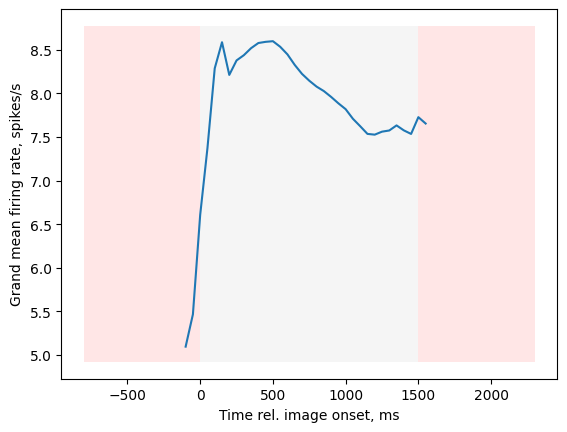

In [21]:
plt.plot(ts, resps.mean((0,-1)) * 1e3)

yl = plt.gca().get_ylim()
plt.fill_betweenx(yl, 0, dur, ec='none', fc='whitesmoke', zorder=-1)
plt.fill_betweenx(yl, dur, dur+iti, ec='none', fc=(1, .9, .9), zorder=-1)
plt.fill_betweenx(yl, -iti, 0, ec='none', fc=(1, .9, .9), zorder=-1)

plt.xlabel('Time rel. image onset, ms')
plt.ylabel('Grand mean firing rate, spikes/s');

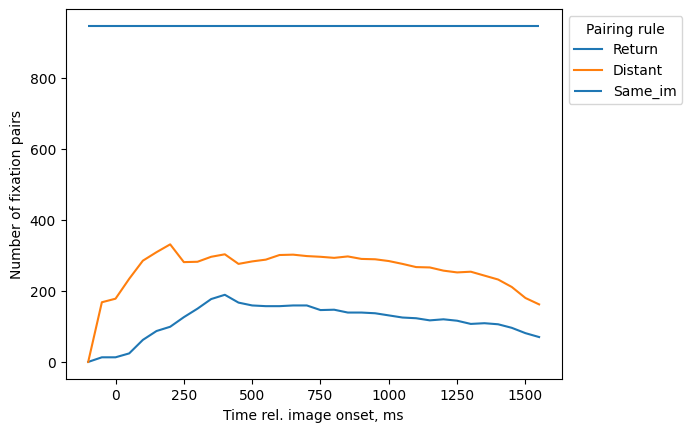

In [22]:
for cond, results in bycond_results.items():
    v = results['n_pairs']
    if hasattr(v, '__len__') and len(v) > 1:
        plt.plot(ts, v, label=cond.capitalize())
    else:
        plt.hlines(v, ts[0], ts[-1], label=cond.capitalize())
plt.legend(loc='upper left', bbox_to_anchor=(1,1), title='Pairing rule')
plt.xlabel('Time rel. image onset, ms')
plt.ylabel('Number of fixation pairs');

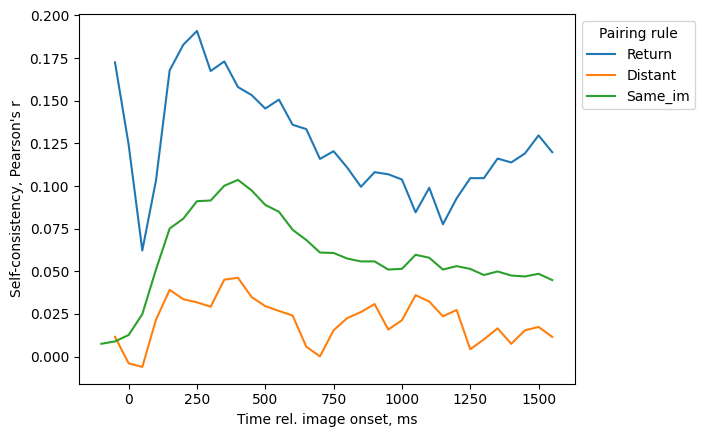

In [23]:
for cond, results in bycond_results.items():
    plt.plot(ts, np.ma.masked_invalid(results['sc']).mean(-1), label=cond.capitalize())
plt.legend(loc='upper left', bbox_to_anchor=(1,1), title='Pairing rule')
plt.xlabel('Time rel. image onset, ms')
plt.ylabel('Self-consistency, Pearson\'s r');